### Escopo para cálculo de parâmetros da aba Maturação 

In [83]:
# Input de dados de pirólise (leitura de planilha .csv)
# Agrupamento de dados (cluster)
# Cálculo de COTa
# Cálculo de IHa = 100 x (S2/(COTa))
# Calculo de Tr sem vitrinita: (IHa - IH)/ IHa
# Cálculo de Ro a partir de Tmax: Ro calculada = (0,0180 x Tmax) - 7,16
# Classificação do querogênio
# Cálculo de Tr por Ro e tipo de querogênio
# Normalização dos valores de Tr na curva log (ln)
# Cálculo de TOC0, S20 e IH0
# Comparação entre os resultados de Tr (Ro x IH)
# Decisão sobre resultados de Tr
# Output (Gráficos e Planilha)  

##### Dependências

In [84]:
%matplotlib inline
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import skfuzzy as fuzz 
from skfuzzy import control as ctrl
from tqdm.auto import tqdm
from IPython.core.magic import register_cell_magic

##### Customização dos gráficos

In [85]:
# keys = plt.rcParams.keys()
# print(keys)
# 'font.sans-serif': "Verdana",

custom_style = {
    'figure.figsize': (8, 6),
    'font.family':'sans-serif',
    'axes.facecolor': 'lightgray',
    'figure.facecolor':'silver',
    'scatter.marker': 'o',
    'font.size': 9,
    'axes.grid': True
    }

##### Input de dados de pirólise (leitura de planilha .csv)

In [86]:
df1 = pd.read_csv("Poços_Marinho/1-ALS-2-AL.csv")
df=df1[["Profundidade","COT","S1","S2","S3","Tmax","IH","IO"]]
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43
...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78


## Lógica Fuzzy

In [87]:

def fuzzy_Maturacao(input_df,**kwargs):
    
    debug = kwargs.get('debug',False) # Se definido como True, exporta também um dataframe com as fácies não definidas
    trust = kwargs.get('trust','COT') # o padrão é confiar em COT

    
    if trust not in ['COT','IH']:
        print(f'Você forneceu a opção "trust={trust}" que não é reconhecida.')
        return 

    # creating output_df
    output_df = input_df
    
    # definição das classes de saida  : note que está adaptada para regras da BES
    # **CLASSIC**
    of_nclass = 7
    of_class = ['A','AB','B','BC','C','CD','D']
    
    # **RECLASSIFICAÇÃO**
    if trust == 'COT':
        of_RE_nclass = 4
        of_RE_class = ['BC+','CD+++','CD++','CD+']
        of_RE_alter = ['BC','CD','CD','CD']
    elif trust == 'IH':
        of_RE_nclass = 4
        of_RE_class = ['B-','B--','BC--','C-']        
        of_RE_alter = ['B','B','BC','C']

    # toc: classes de carbono orgânico total
    toc_nclass = 3
    toc_class = ['low','high','very high']
    toc_class_bounds = [[0,1],
                    [1,3],
                    [3,20]]
    
    # hi: classes de índice de hidrogênio
    hi_nclass = 7
    hi_class = ['ultra low','very low','low','intermediate','high','very high','ultra high']
    hi_class_bounds = [[0,50],
                   [50,125],
                   [125,250],
                   [250,400],
                   [400,650],
                   [650,850],
                   [850,1500]]

    #oi: Classes de índice de oxigênio (regime)
    oi_nclass = 7
    oi_class =  ['ultra low','very low','low','mid low','mid high','mid wide','wide']
    oi_class_bounds = [[10,30],
                   [20,50],
                   [30,80],
                   [40,80],
                   [50,150],
                   [40,150],
                   [20,200]]
    
    #oi_RE: Classes de índice de oxigênio (regime) para reclassificação
    oi_RE_nclass = 3
    oi_RE_class =  ['low','mid wide','high']
    oi_RE_class_bounds = [[10,80],
                          [40,150],
                          [120,200]]   
    

    # Definição do modelo fuzzy (com base nos valores min/max) e resolução definida abaixo
    dtoc = 0.5
    dhi = 1
    doi = 1

    TOC = ctrl.Antecedent(np.arange(np.min(toc_class_bounds),np.max(toc_class_bounds), dtoc),'COT')
    HI = ctrl.Antecedent(np.arange(np.min(hi_class_bounds),np.max(hi_class_bounds), dhi),'IH')
    OI = ctrl.Antecedent(np.arange(np.min(oi_class_bounds),np.max(oi_class_bounds), doi),'IO')
    OI_RE = ctrl.Antecedent(np.arange(np.min(oi_RE_class_bounds),np.max(oi_RE_class_bounds), doi),'oi_re')
    
    # Consequents
    Organic_Facies = ctrl.Consequent(np.arange(0, of_nclass + 1, 1), 'of')
    Organic_Facies_RE = ctrl.Consequent(np.arange(0, of_nclass + 1, 1), 'of_re')

    # Inicialização
    for ii,tclass in enumerate(toc_class):
        #print(f'{ii} {tclass}') # para paranoicos
        if ii == 0:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [np.min(toc_class_bounds),
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             toc_class_bounds[ii+1][0]])
        elif ii == len(toc_class)-1:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [toc_class_bounds[ii-1][1],
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             np.max(toc_class_bounds)])
        else:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [toc_class_bounds[ii-1][1],
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             toc_class_bounds[ii+1][0]])
    #TOC.view() # para paranoicos
    for ii,hiclass in enumerate(hi_class):
        #print(f'{ii} {hiclass}') para paranoicos
        if ii == 0:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.min(hi_class_bounds),
                                             hi_class_bounds[ii][0],
                                             hi_class_bounds[ii][1],
                                             np.mean(hi_class_bounds[ii+1][:])])
        elif ii == len(hi_class)-1:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.mean(hi_class_bounds[ii-1][:]),
                                             hi_class_bounds[ii][0],
                                             hi_class_bounds[ii][1],
                                             np.max(hi_class_bounds)])
        else:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.mean(hi_class_bounds[ii-1][:]),
                                            hi_class_bounds[ii][0],
                                            hi_class_bounds[ii][1],
                                            np.mean(hi_class_bounds[ii+1][:])])
    #HI.view() # para paranoicos
    
    # *** NOTA para OI uma função de pertinência gaussiana é usada 
    # esta escolha foi feita com base na ampla distribuição de OI
    
    for ii,oiclass in enumerate(oi_class):
        #print(f'{ii} {oiclass}') # para paranoicos
        OI[oiclass] = fuzz.gaussmf(OI.universe,np.mean(oi_class_bounds[ii][:]),
                                         np.std(oi_class_bounds[ii][:]))

    for ii,oiREclass in enumerate(oi_RE_class):
        #print(f'{ii} {oiREclass}') # para paranoicos
        OI_RE[oiREclass] = fuzz.gaussmf(OI_RE.universe,np.mean(oi_RE_class_bounds[ii][:]),
                                         np.std(oi_RE_class_bounds[ii][:]))
        
    #OI.view() # para paranoicos

    # função de pertinência de saída (triangular CRISP)
    for ii,ofclass in enumerate(of_class):
        #print(f'{ii} {ofclass}') # para paranoicos
        Organic_Facies[ofclass] = fuzz.trimf(Organic_Facies.universe,[ii-1,ii,ii+1])
    
    for ii,ofREclass in enumerate(of_RE_class):
        #print(f'{ii} {ofREclass}') # para paranoicos
        Organic_Facies_RE[ofREclass] = fuzz.trimf(Organic_Facies_RE.universe,[ii-1,ii,ii+1])

    # Organic_Facies.view() # para paranoicos

    # FUZZY rules   

    rule1 = ctrl.Rule(TOC['very high'] & HI['ultra high'] & OI['ultra low'], Organic_Facies['A']) 
    rule2 = ctrl.Rule(TOC['very high'] & HI['very high'] & OI['very low'], Organic_Facies['AB'])
    rule3 = ctrl.Rule(TOC['very high'] & HI['high'] & OI['low'], Organic_Facies['B'])
    rule4 = ctrl.Rule(TOC['high'] & HI['intermediate'] & OI['mid low'], Organic_Facies['BC'])
    rule5 = ctrl.Rule(TOC['high'] & HI['low'] & OI['mid high'], Organic_Facies['C'])
    rule6 = ctrl.Rule(TOC['low'] & HI['very low'] & OI['mid wide'], Organic_Facies['CD'])
    rule7 = ctrl.Rule(TOC['low'] & HI['ultra low'] & OI['wide'], Organic_Facies['D'])
    
    # Note que estas são as regras para reclassificação
    
    if trust=='COT':
        rule8 = ctrl.Rule(TOC['high'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['BC+'])
        rule9 = ctrl.Rule(TOC['low'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['CD+++'])
        rule10 = ctrl.Rule(TOC['low'] & HI['intermediate'] & OI_RE['mid wide'], Organic_Facies_RE['CD++'])
        rule11 = ctrl.Rule(TOC['low'] & HI['low'] & OI_RE['high'], Organic_Facies_RE['CD+'])
    elif trust=='IH':
        rule8 = ctrl.Rule(TOC['high'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['B-'])
        rule9 = ctrl.Rule(TOC['low'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['B--'])
        rule10 = ctrl.Rule(TOC['low'] & HI['intermediate'] & OI_RE['mid wide'], Organic_Facies_RE['BC--'])
        rule11 = ctrl.Rule(TOC['low'] & HI['low'] & OI_RE['high'], Organic_Facies_RE['C-'])       

    maturation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, \
                                          rule5, rule6, rule7])
    
    maturation_ctrl_RE = ctrl.ControlSystem([rule8, rule9, rule10, rule11])
    
    # driver fuzzy começa aqui
    maturation_apply = ctrl.ControlSystemSimulation(maturation_ctrl)
    maturation_apply_RE = ctrl.ControlSystemSimulation(maturation_ctrl_RE)

    # loop principal para entrada inteira
    output_df = output_df.assign(of=-99.0)
    output_df = output_df.assign(of_class='??')
    output_df = output_df.assign(quality='erro')
    output_df = output_df.assign(observ='erro de entrada')

    # *** lida com fora dos limites para qualquer entrada
    for index,row in tqdm(input_df.iterrows(),total=len(input_df)):
        #print(f'Depth:{row.Depth} inputs:[{row.toc:.2f}:{row.hi:4.0f}:{row.oi:4.0f}]')
        if row.COT < np.min(toc_class_bounds) or row.COT >np.max(toc_class_bounds):
            print(f'***aviso: toc fora dos limites Profundidade:{row.Profundidade} inputs:[{row.COT:.2f}:{row.IH:4.0f}:{row.IO:4.0f}]')
        if row.IH < np.min(hi_class_bounds) or row.IH >np.max(hi_class_bounds):
            print(f'***aviso: hi fora dos limites Profundidade:{row.Profundidade} inputs:[{row.COT:.2f}:{row.IH:4.0f}:{row.IO:4.0f}]')
        if row.IO < np.min(oi_class_bounds) or row.IO >np.max(oi_class_bounds):
            print(f'***aviso: oi fora dos limites Profundidade:{row.Profundidade} inputs:[{row.COT:.2f}:{row.IH:4.0f}:{row.IO:4.0f}]')
        maturation_apply.inputs({'COT': float(row.COT),'IH': float(row.IH),'IO': float(row.IO)})
        maturation_apply_RE.inputs({'COT': float(row.COT),'IH': float(row.IH),'oi_re': float(row.IO)})
        
        try:
            maturation_apply.compute()
            
            # arredonda o float de saida de desfuzzificação para 2 casas decimais
            output_df.loc[index,'of'] = round(maturation_apply.output["of"],2)
            # utiliza o inteiro mais próximo para escolher a classe
            ii_class = np.rint(maturation_apply.output["of"]) 
            
            output_df.loc[index,'of_class'] = of_class[int(ii_class)]
            output_df.loc[index,'quality'] = 'bom'
            output_df.loc[index,'observ'] = ''
            
        except:
            try:
                maturation_apply_RE.compute()
                
                # arredonda o float de saida de desfuzzificação para 2 casas decimais
                output_df.loc[index,'of'] = round(maturation_apply_RE.output["of_re"],2)
                # utiliza o inteiro mais próximo para escolher a classe
                ii_class = np.rint(maturation_apply_RE.output["of_re"]) 
                output_df.loc[index,'of_class'] = of_RE_alter[int(ii_class)]
                output_df.loc[index,'quality'] = f'cautela'
                output_df.loc[index,'observ'] = f'cautela {of_RE_class[int(ii_class)]}'
            
            except:
            
                # em caso de erro de desfuzzificação, mostra onde ocorreu
                print(f' Erro de defuzzing (RECLASS) no índice:{index} Profundidade:{row.Profundidade:.2f} m')
            
            if debug:
                print(f'Debugging...',end='')
                atclass = ''
                ahiclass = ''
                aoiclass = ''
                
                for ii,tclass in enumerate(toc_class):
                    if row.COT >= toc_class_bounds[ii][0] and row.COT <= toc_class_bounds[ii][1]:
                        atclass = f'{atclass}|{tclass}'
                atclass = f'{atclass}|'
                        
                for ii,hiclass in enumerate(hi_class):
                    if row.IH >= hi_class_bounds[ii][0] and row.IH <= hi_class_bounds[ii][1]:
                        ahiclass = f'{ahiclass}|{hiclass}'
                ahiclass = f'{ahiclass}|'
                        
                for ii,oiclass in enumerate(oi_RE_class):
                    if row.IO >= oi_RE_class_bounds[ii][0] and row.IO <= oi_RE_class_bounds[ii][1]:
                        aoiclass = f'{aoiclass}|{oiclass}'
                aoiclass = f'{aoiclass}|'
                
                print(f'COT:{row.COT:.3f} COT_class {atclass} '
                      f'IH {row.IH:.1f} IH_class {ahiclass} '
                      f'IO {row.IO:.1f} IO_class {aoiclass} ')
        

    return output_df

#### Classificação de Facies Orgânicas

In [88]:

df_out = fuzzy_Maturacao(df,func='flat',debug=True)
df["Fácie Orgânica"]=df_out["of_class"]
df

 72%|███████▏  | 98/136 [00:00<00:00, 491.95it/s]

 Erro de defuzzing (RECLASS) no índice:13 Profundidade:819.80 m
Debugging...COT:3.760 COT_class |very high| IH 290.4 IH_class |intermediate| IO 48.7 IO_class |low|mid wide| 
Debugging...COT:0.140 COT_class |low| IH 214.3 IH_class |low| IO 142.9 IO_class |mid wide|high| 
***aviso: oi fora dos limites Profundidade:2421.8 inputs:[0.24:  83: 208]


100%|██████████| 136/136 [00:00<00:00, 495.77it/s]


,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C
...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D


#### Gráfico de correlação entre IH, COT e IO

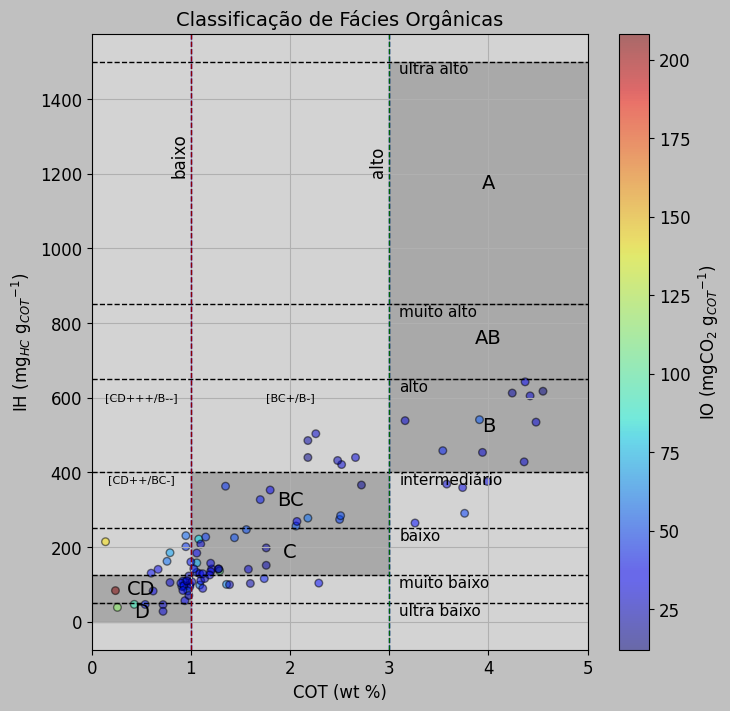

In [131]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(8,8))

# definição das classes e áreas 
D_class = [(0,0),(0,50),(1,50),(1,0),(0,0)]
CD_class = [(0,50),(0,125),(1,125),(1,50),(0,50)]
C_class = [(1,125),(3,125),(3,250),(1,250),(1,125)]
BC_class = [(1,250),(3,250),(3,400),(1,400),(1,250)]
B_class = [(3,400),(20,400),(20,650),(3,650),(3,400)]
AB_class = [(3,650),(20,650),(20,850),(3,850),(3,650)]
A_class = [(3,850),(20,850),(20,1500),(3,1500),(3,850)]

ax.add_patch(plt.Polygon(D_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(CD_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(C_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(BC_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(B_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(AB_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(A_class,color='gray',alpha=0.5))

# classes
plt.text(0.5,25,'D',fontsize=14,va='center',ha='center')
plt.text(0.5,87.5,'CD',fontsize=14,va='center',ha='center')
plt.text(2,187.5,'C',fontsize=14,va='center',ha='center')
plt.text(2,325,'BC',fontsize=14,va='center',ha='center')
plt.text(4,525,'B',fontsize=14,va='center',ha='center')
plt.text(4,759,'AB',fontsize=14,va='center',ha='center')
plt.text(4,1175,'A',fontsize=14,va='center',ha='center')

# plota os valores em scatter ###
plt.scatter(df_out["COT"],df_out["IH"],c=df_out["IO"],edgecolor='black',
            s=30,cmap=cm.jet,alpha=0.5,label='SES189')

# ###############################
plt.xlabel('COT (wt %)',fontsize=12)
plt.xlim([0,5])
plt.ylabel('IH (mg$_{HC}$ g$_{COT}$$^{-1}$)',fontsize=12)
plt.title('Classificação de Fácies Orgânicas',fontsize=14)

his = [50,125,250,400,650,850,1500]
his_text = ['ultra baixo','muito baixo','baixo','intermediário','alto','muito alto','ultra alto']

for yp,histext in enumerate(his_text):
    plt.axhline(his[yp],linestyle='--',color='k',linewidth=1)
    plt.text(3.1,his[yp],histext,fontsize=11,va='top')
    
cots = [1,3]
cots_text = ['baixo','alto']
for xp,cotstext in enumerate(cots_text):
    plt.axvline(cots[xp],linestyle='--',color='b',linewidth=1)
    plt.text(cots[xp]-0.2,1200,cotstext,fontsize=12,rotation=90,ha='left')
    
plt.axvline(1,linestyle='--',color='darkred',linewidth=1)
plt.axvline(3,linestyle='--',color='darkgreen',linewidth=1)

# classificação extra
plt.text(0.5,600,'[CD+++/B--]',fontsize=8,va='center',ha='center')
plt.text(2,600,'[BC+/B-]',fontsize=8,va='center',ha='center')
plt.text(0.5,380,'[CD++/BC-]',fontsize=8,va='center',ha='center')

cbar = plt.colorbar()
cbar.ax.set_ylabel('IO (mgCO$_2$ g$_{COT}$$^{-1}$)', rotation=90,fontsize=12)

plt.show()


## Agrupamento por parâmetros de pirólise

/home/rodrigosobrinho/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


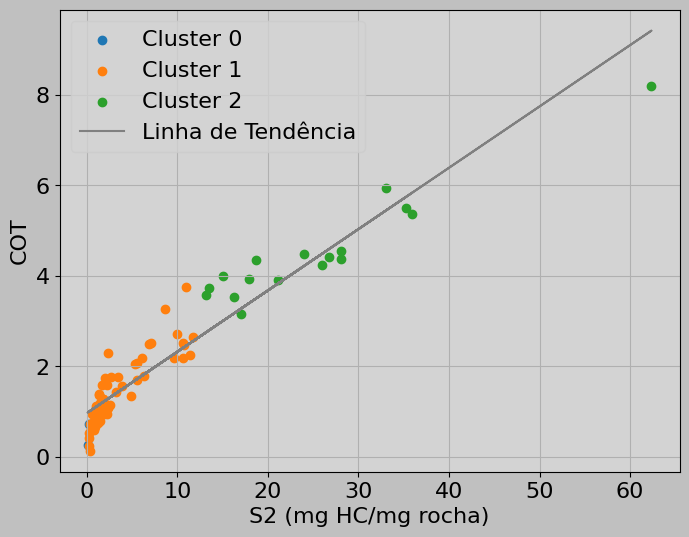

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1
...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0


In [90]:
# Number of clusters you want to create
num_clusters = 3  

# Extract the columns for clustering

X = df[["COT","S1","S2","S3","Tmax"]].fillna(0)

# Optional: Scale the data (if needed)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)  # Use X_scaled if you scaled the data, otherwise use X

# Get cluster assignments and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add cluster labels to the original data frame
df['Cluster'] = cluster_labels

# Scatter plot
plt.figure(figsize=(8, 6))

# Plot data points for each cluster
for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_data["S2"], cluster_data["COT"], label=f'Cluster {cluster_id}')

# Extract data from DataFrame
df1=df.dropna(subset=["COT","S2"])
x_data = df1['S2'].values.reshape(-1, 1)
y_data = df1['COT'].values

# Fit linear regression model
model = LinearRegression()
model.fit(x_data, y_data)

# Get the slope (coefficient) and y-intercept of the trend line
slope = model.coef_[0]
intercept = model.intercept_


# Plot the trend line
plt.plot(x_data, model.predict(x_data), color='gray', label='Linha de Tendência')

plt.xlabel("S2 (mg HC/mg rocha)")
plt.ylabel("COT")
plt.title('')
plt.legend()
plt.grid(True)
plt.style.use(custom_style)
plt.show()
df

##### Equação de regressão linear para cada cluster

In [91]:
models = {}

for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    x_values = cluster_data[["S2"]].fillna(value=0)
    y_values = cluster_data["COT"]
    model = LinearRegression()
    model.fit(x_values, y_values)
    models[cluster_id] = model

# Print the linear regression equations for each cluster
dic={}
for cluster_id, model in models.items():
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"Cluster {cluster_id} - y = {slope:.2f} * x + {intercept:.2f}")
    #dic={cluster_id:intercept}
    dic[cluster_id]=intercept
    print(dic)

Cluster 0 - y = -0.85 * x + 0.71
{0: 0.7080097087378642}
Cluster 1 - y = 0.19 * x + 0.79
{0: 0.7080097087378642, 1: 0.7940621234463973}
Cluster 2 - y = 0.09 * x + 2.15
{0: 0.7080097087378642, 1: 0.7940621234463973, 2: 2.146608469927515}


In [92]:
dic[1]

0.7940621234463973

## Simulações 

##### Cálculo de COT ativo utilizando regressão linear

In [93]:
COTativo=[]
for idx,row in df.iterrows():
    #print(row["Cluster"])
    Cluster=row["Cluster"]
    COT=row["COT"]
    intercept=dic[Cluster]
    COTa= COT- intercept
    COTativo.append(COTa)
df["COTa"]=COTativo
df
COT_cor=[]
for i in df["COTa"]:
    if i >= 0:
        COT_cor.append(i)
    else:
        COT_cor.append(0)
df["COTa"]=COT_cor
df


,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,COTa
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,1.705938
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,1.715938
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,1.385938
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,1.265938
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,0.495938
...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,0.000000
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,0.000000
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,0.000000
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,0.011990


##### Cálculo de IH0ativo
* IHa = 100 x (S2/(COTa))

In [94]:
IHa = (100*df["S2"]/df["COTa"])
IHa_cor=[]
for i in IHa:
    if i<0:
        IHa_cor.append(0)
    elif i>999:
        IHa_cor.append(999)
    else:
        IHa_cor.append(i) # Eliminar valores
df["IH0a"]= IHa_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,COTa,IH0a
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,1.705938,401.538655
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,1.715938,415.516208
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,1.385938,436.527503
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,1.265938,417.082078
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,0.495938,354.883158
...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,0.000000,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,0.000000,999.000000
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,0.000000,999.000000
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,0.011990,999.000000


##### Calculo da Taxa de Transformação sem Ro (IH)
* (IHa - IH)/ IHa

In [95]:
df["Taxa de Transformação (IH)"] = ((df["IH0a"]-df["IH"])/df["IH0a"])
TrIH=[]
for i in df["Taxa de Transformação (IH)"]:
    if i<0:
        TrIH.append(0)
    elif i>1:
        TrIH.append=1
    else:
        TrIH.append(i)
df["Taxa de Transformação (IH)"]=TrIH
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,COTa,IH0a,Taxa de Transformação (IH)
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,1.705938,401.538655,0.317625
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,1.715938,415.516208,0.316368
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,1.385938,436.527503,0.364255
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,1.265938,417.082078,0.385469
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,0.495938,354.883158,0.615564
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,0.000000,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,0.000000,999.000000,0.954124
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,0.000000,999.000000,0.961502
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,0.011990,999.000000,0.972192


##### Cálculo de Ro a partir de Tmax
* Ro calculada = (0,0180 x Tmax) - 7,16

In [96]:
df["Ro (calculada)"] = (0.0180*df["Tmax"])-7.16
Roc_cor=[]
for i in df["Ro (calculada)"]:
    if i<0:
        Roc_cor.append(0)
    else:
        Roc_cor.append(i)
df["Ro (calculada)"]=Roc_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada)
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,1.705938,401.538655,0.317625,0.580
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,1.715938,415.516208,0.316368,0.562
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,1.385938,436.527503,0.364255,0.580
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,1.265938,417.082078,0.385469,0.580
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,0.495938,354.883158,0.615564,0.544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,0.000000,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,0.000000,999.000000,0.954124,0.814
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,0.000000,999.000000,0.961502,NaN
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,0.011990,999.000000,0.972192,NaN


#### Classificação do querogênio

In [97]:

K = []
for i in df["Fácie Orgânica"]:
    if i == "A":
        a="I"
    elif i == "AB":
        a="I/II"
    elif i == "B":
        a="II"
    elif i == "BC":
        a="II/III"
    elif i == "C":
        a="III"
    elif i == "CD":
        a="III/IV"
    else:
        a="IV"
    K.append(a)
querogênio=pd.DataFrame(K)
df["Querogênio"]=querogênio
df


,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,1.705938,401.538655,0.317625,0.580,II/III
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,1.715938,415.516208,0.316368,0.562,II/III
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,1.385938,436.527503,0.364255,0.580,II/III
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,1.265938,417.082078,0.385469,0.580,II/III
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,0.495938,354.883158,0.615564,0.544,III
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,0.000000,NaN,NaN,NaN,III/IV
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,0.000000,999.000000,0.954124,0.814,IV
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,0.000000,999.000000,0.961502,NaN,IV
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,0.011990,999.000000,0.972192,NaN,IV


## Cálculo da Taxa de Transformação

#### End Member para tipo de querogênio 

##### Faixas de valores para centroides:

* Tipo I: {IH > 600} ___ {S1/S3 > 15}
* Tipo II: {IH > 300 and IH <= 600} ___ {S1/S3 > 10 and S1/S3 <15}
* Tipo II/III: {IH > 200 and IH <=300} ___ {S1/S3 > 5 and S1/S3 < 10]
* Tipo III: {IH > 50 and IH <= 200} ___ {S1/S3 > 1 and S1/S3 < 5}
* Tipo IV: {IH <= 50} ___ {S1/S3 > 1}

In [98]:
df["S2/S3"]=df["S2"]/df["S3"]
T1 = []
T2 = []
T3 = []
T4 = []
for index, row in df.iterrows():
    i = row['IH']
    j = row['S2/S3']
    dist12=np.sqrt(((17.5-11.25)**2+((800-425)**2)))
    dist23=np.sqrt(((11.25-3.25)**2+((425-150)**2)))
    dist34=np.sqrt(((3.25-0.5)**2+((150-25)**2)))
    dista1=np.sqrt(((j-17.5)**2+((i-800)**2)))
    dista2=np.sqrt(((j-11.25)**2+((i-425)**2)))
    dista3=np.sqrt(((j-3.25)**2+((i-150)**2)))
    dista4=np.sqrt(((j-0.5)**2+((i-25)**2))) 
    bd1=(((dist12)**2)-((dista2)**2)+((dista1)**2))/(2*dist12)
    bd2=(((dist23)**2)-((dista3)**2)+((dista2)**2))/(2*dist23)
    bd3=(((dist34)**2)-((dista4)**2)+((dista3)**2))/(2*dist34)
    pct1=((bd1/dist12)*100).round(2)
    pct2=((bd2/dist23)*100).round(2)
    pct3=((bd3/dist34)*100).round(2)
    if i >= 800:
        T1.append(100) 
        T2.append(0)
        T3.append(0)
        T4.append(0) 
    elif i >= 425 and i <=800:
        T1.append(100-pct1) 
        T2.append(pct1)
        T3.append(0)
        T4.append(0) 
    elif i >= 150 and i < 425:
        T1.append(0) 
        T2.append(100-pct2)
        T3.append(pct2)
        T4.append(0) 
    elif i>=25 and i<150:
        T1.append(0) 
        T2.append(0)
        T3.append(100-pct3)
        T4.append(pct3)
    elif i>=0 and i<25:
        T1.append(0) 
        T2.append(0)
        T3.append(0)
        T4.append(100)
    else:
        T1.append("") 
        T2.append("")
        T3.append("")
        T4.append("")

df["% Tipo I"]=T1
df["% Tipo II"]=T2
df["% Tipo III"]=T3
df["% Tipo IV"]=T4
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio,S2/S3,% Tipo I,% Tipo II,% Tipo III,% Tipo IV
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,1.705938,401.538655,0.317625,0.580,II/III,5.614754,0,45.08,54.92,0
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,1.715938,415.516208,0.316368,0.562,II/III,5.614173,0,48.73,51.27,0
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,1.385938,436.527503,0.364255,0.580,II/III,4.801587,0,46.35,53.65,0
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,1.265938,417.082078,0.385469,0.580,II/III,4.800000,0,38.64,61.36,0
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,0.495938,354.883158,0.615564,0.544,III,1.294118,0,0,89.11,10.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,0.000000,NaN,NaN,NaN,III/IV,NaN,,,,
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,0.000000,999.000000,0.954124,0.814,IV,1.736842,0,0,16.68,83.32
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,0.000000,999.000000,0.961502,NaN,IV,0.333333,0,0,10.76,89.24
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,0.011990,999.000000,0.972192,NaN,IV,1.000000,0,0,2.23,97.77


#### Decisão sobre tipo de Querogênio

In [104]:
x=['% Tipo I', '% Tipo II', '% Tipo III', '% Tipo IV']
TI=df["% Tipo I"].dropna().values.sum()
TII=df["% Tipo II"].dropna().values.sum()
TIII=df["% Tipo III"].dropna().values.sum()
TIV=df["% Tipo IV"].dropna().values.sum()
data=[TI,TII,TIII,TIV]
plt.bar(x,data,0.4, facecolor="dimgray")
#custom_labels_x = ['% Tipo I', '% Tipo II', '% Tipo III', '% Tipo IV']
#plt.xticks(np.arange(1, len(custom_labels_x) + 1), custom_labels_x)
plt.style.use(custom_style)
plt.ylabel("% Tipo de Querogênio")
#plt.savefig("Boxplot_K.pdf")
plt.show()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U1')) -> None

#### Cálculo de Tr por Ro e tipo de querogênio
* Tipo_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
* Tipo_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
* Tipo_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)


In [102]:
Ro = df["Ro (calculada)"].mean()
print("Valor medio da Ro calculada:", Ro )
#for Ro in df["Ro (calculada)"]:
Eq_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
Eq_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
Eq_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)
    
if TI > TII and TI > TIII and TI > TIV:
    TRo=Eq_I
    print("Querogênio Tipo I")
elif TII > TI and TII > TIII and TII > TIV:
    TRo=Eq_II
    print("Querogênio Tipo II")
elif TIII > TI and TIII > TII and TIII > TIV:
    TRo=Eq_III
    print("Querogênio Tipo III")
else:
    TRo=0
    print("Querogênio Tipo IV")
print("Taxa de TRansformação (Ro):", TRo)

if i > 1:
    TRo = 1
elif TRo < 0:
    TRo = 0
else:
    TRo = TRo
#df["Taxa de Transformação (Ro)"]=TRo
#df

Valor medio da Ro calculada: 0.6936129032258057
Querogênio Tipo III
Taxa de TRansformação (Ro): 0.05867102297416635


#### Normalização dos valores de Tr na curva log (ln)

In [103]:
L = float(input("Lâmina d'água: "))


MRo = TRo#df["Taxa de Transformação (Ro)"].mean()
MIH = df["Taxa de Transformação (IH)"].median()
MinIH = df["Taxa de Transformação (IH)"].min()
MedIH = df["Taxa de Transformação (IH)"].mean()

    # 4. Ajustar uma curva logaritmica com a profundidade da lamina dagua e a profundidade final e o tr na lamina dagua (zero) e o tr na profundidade final (mediana ou mínimo), utilizando scipy curve_fit

# Cálculo para valores de Ro calculada
x1 = [L, df["Profundidade"].max()]
y1 = [0, MRo]

log_fit = scipy.optimize.curve_fit(lambda t, a1, b1: a1 + b1 * np.log(t), x1, y1)
a1 = log_fit[0][0]
b1 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_Ro_Log'] = a1 + b1 * np.log(df["Profundidade"])

#================================================#

# Cálculo para valores de IH (mediana)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (mdn)'] = a2 + b2 * np.log(df["Profundidade"])
df

#================================================#

# Cálculo para valores de IH (mínimo)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MinIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (min)'] = a2 + b2 * np.log(df["Profundidade"])
df
#================================================#

# Cálculo para valores de IH (média)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MedIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (med)'] = a2 + b2 * np.log(df["Profundidade"])
df
    # Extra: aplicando novamente filtro para que tr seja 0 abaixo da lamina d'agua


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,...,Querogênio,S2/S3,% Tipo I,% Tipo II,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med)
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,...,II/III,5.614754,0,45.08,54.92,0,0.037930,0.424264,0.136523,0.401358
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,...,II/III,5.614173,0,48.73,51.27,0,0.038291,0.428294,0.137819,0.405171
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,...,II/III,4.801587,0,46.35,53.65,0,0.038640,0.432204,0.139078,0.408870
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,...,II/III,4.800000,0,38.64,61.36,0,0.038980,0.436002,0.140300,0.412463
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,...,III,1.294118,0,0,89.11,10.89,0.039310,0.439694,0.141488,0.415955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,...,III/IV,NaN,,,,,0.058374,0.652928,0.210104,0.617677
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,...,IV,1.736842,0,0,16.68,83.32,0.058384,0.653048,0.210143,0.617791
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,...,IV,0.333333,0,0,10.76,89.24,0.058438,0.653648,0.210336,0.618358
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,...,IV,1.000000,0,0,2.23,97.77,0.058555,0.654958,0.210757,0.619598


#### Gráficos das curvas Log para Taxa de Transformação

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


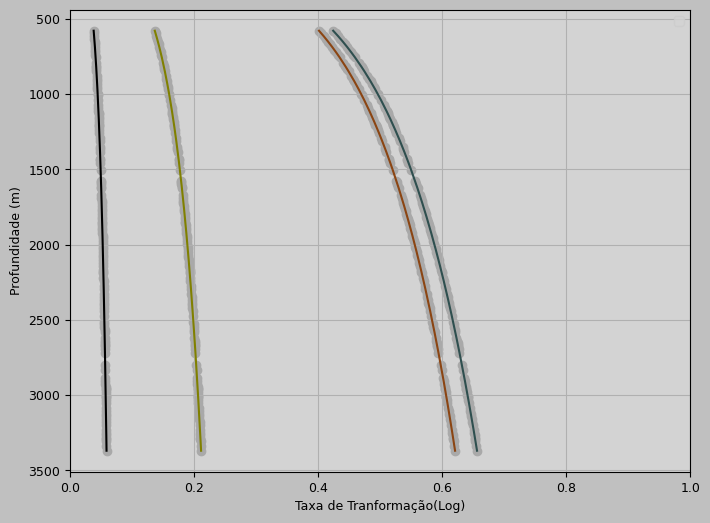

In [105]:
fig = plt.figure()
ax = fig.add_subplot()
y = df["Profundidade"].values
mdn = df["Tr_IH_Log (mdn)"].values
min = df["Tr_IH_Log (min)"].values
med = df["Tr_IH_Log (med)"].values
Ro = df["Tr_Ro_Log"].values
ax.plot(mdn, y, color='darkslategray')
ax.plot(min, y, color='olive')
ax.plot(med, y, color='saddlebrown')
ax.plot(Ro, y, color='black')
ax.scatter(mdn, y, color='darkgray')
ax.scatter(min, y, color='darkgray')
ax.scatter(med, y, color='darkgray')
ax.scatter(Ro, y, color='darkgray')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação(Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.savefig("Curvas_Tr.pdf")
plt.show()

#### Decisão sobre a curva Log 

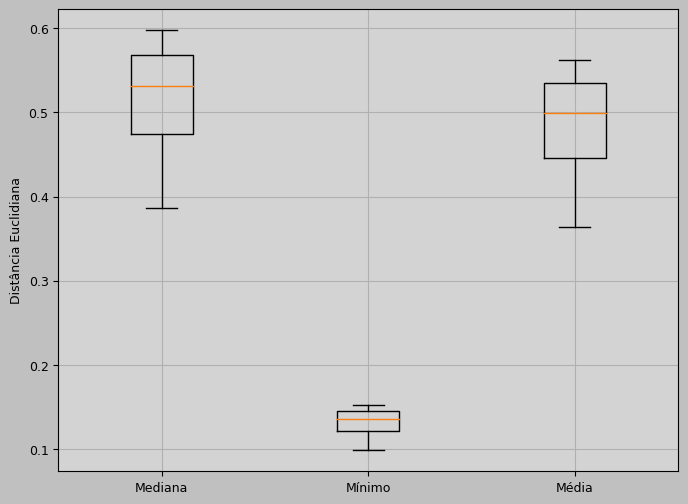

In [106]:
sub1=np.sqrt((df["Tr_IH_Log (mdn)"]-df["Tr_Ro_Log"])**2)
sub2=np.sqrt((df["Tr_IH_Log (min)"]-df["Tr_Ro_Log"])**2)
sub3=np.sqrt((df["Tr_IH_Log (med)"]-df["Tr_Ro_Log"])**2)
data=[sub1,sub2,sub3]
plt.boxplot(data)
custom_labels_x = ['Mediana', 'Mínimo', 'Média']
plt.xticks(np.arange(1, len(custom_labels_x) + 1), custom_labels_x)
plt.style.use(custom_style)
plt.ylabel("Distância Euclidiana")
plt.savefig("Boxplot_DistEuc.pdf")
plt.show()


#### Gráfico final (output) para Taxa de Transformação

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


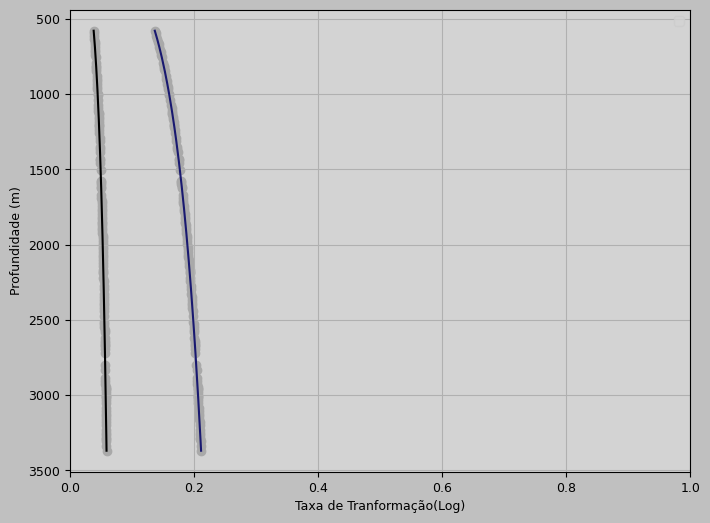

In [107]:
fig = plt.figure()
ax = fig.add_subplot()
#y = df["Profundidade"].values
#mdn = df["Tr_IH_Log (mdn)"].values
#min = df["Tr_IH_Log (min)"].values
#med = df["Tr_IH_Log (med)"].values
#Ro = df["Tr_Ro_Log"].values

if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
    a=mdn
elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
    a=min
else:
    a=med

ax.plot(a, y, color='midnightblue')
ax.plot(Ro, y, color='black')
ax.scatter(a, y, color='darkgray')
ax.scatter(Ro, y, color='darkgray')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação(Log)")
plt.ylabel("Profundidade (m)")
plt.savefig("Boxplot_Tr.pdf")
plt.style.use(custom_style)
plt.show()

##### Cálculo de TOC0, S20 e IH0
* S20 = S2 / (1 - Tr)
* COT0 = COTr + ((S2 x tr)/(1 - Tr))x0,086
* IH0 = S20/COT0

In [108]:
Tr = df["Taxa de Transformação (IH)"]
df["S20"]=df["S2"]/(1-Tr)
df["COT0"]=df["COT"]+((df["S2"]*Tr)/(1-Tr))*0.086
df["IH0"]=100*df["S20"]/df["COT0"]
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,...,% Tipo II,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,...,45.08,54.92,0,0.037930,0.424264,0.136523,0.401358,10.038466,2.774208,361.849796
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,...,48.73,51.27,0,0.038291,0.428294,0.137819,0.405171,10.429594,2.793765,373.316793
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,...,46.35,53.65,0,0.038640,0.432204,0.139078,0.408870,9.516400,2.478110,384.018410
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,...,38.64,61.36,0,0.038980,0.436002,0.140300,0.412463,8.591914,2.344825,366.420316
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,...,0,89.11,10.89,0.039310,0.439694,0.141488,0.415955,4.578131,1.532359,298.763535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,...,,,,0.058374,0.652928,0.210104,0.617677,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,...,0,16.68,83.32,0.058384,0.653048,0.210143,0.617791,7.193323,1.310246,549.005629
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,...,0,10.76,89.24,0.058438,0.653648,0.210336,0.618358,2.597504,0.474785,547.090170
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,...,0,2.23,97.77,0.058555,0.654958,0.210757,0.619598,7.192225,1.321331,544.316518


#### Cálculo de OSI

In [109]:
df["OSI"]=((df["S1"]/df["COT"])*100)
df.to_csv("Reunião_PR4_08_23.csv")
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,...,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0,OSI
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,...,54.92,0,0.037930,0.424264,0.136523,0.401358,10.038466,2.774208,361.849796,12.800000
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,...,51.27,0,0.038291,0.428294,0.137819,0.405171,10.429594,2.793765,373.316793,11.553785
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,...,53.65,0,0.038640,0.432204,0.139078,0.408870,9.516400,2.478110,384.018410,10.091743
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,...,61.36,0,0.038980,0.436002,0.140300,0.412463,8.591914,2.344825,366.420316,12.621359
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,...,89.11,10.89,0.039310,0.439694,0.141488,0.415955,4.578131,1.532359,298.763535,13.178295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,...,,,0.058374,0.652928,0.210104,0.617677,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,...,16.68,83.32,0.058384,0.653048,0.210143,0.617791,7.193323,1.310246,549.005629,27.777778
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,...,10.76,89.24,0.058438,0.653648,0.210336,0.618358,2.597504,0.474785,547.090170,38.461538
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,...,2.23,97.77,0.058555,0.654958,0.210757,0.619598,7.192225,1.321331,544.316518,27.777778


#### Gráfico OSI

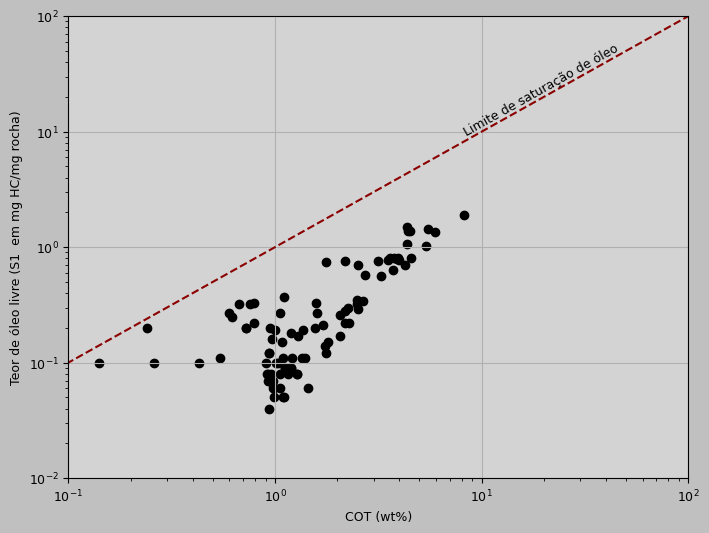

In [110]:
plt.plot([0,100],[0,100], color="darkred", linestyle="--")
plt.scatter(df["COT"], df["S1"], color="black")
plt.ylabel("Teor de óleo livre (S1  em mg HC/mg rocha)")
plt.xlabel("COT (wt%)")
plt.text(8.0, 9.3, "Limite de saturação de óleo", rotation=29.3)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.1,100.0)
plt.ylim(0.01,100.0)
plt.show()

#### Diagrama de Van Krevelen

In [111]:
df["S2/S3"]=df["S2"]/df["S3"]
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Fácie Orgânica,Cluster,...,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0,OSI
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,BC,1,...,54.92,0,0.037930,0.424264,0.136523,0.401358,10.038466,2.774208,361.849796,12.800000
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,BC,1,...,51.27,0,0.038291,0.428294,0.137819,0.405171,10.429594,2.793765,373.316793,11.553785
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,BC,1,...,53.65,0,0.038640,0.432204,0.139078,0.408870,9.516400,2.478110,384.018410,10.091743
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,BC,1,...,61.36,0,0.038980,0.436002,0.140300,0.412463,8.591914,2.344825,366.420316,12.621359
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,C,1,...,89.11,10.89,0.039310,0.439694,0.141488,0.415955,4.578131,1.532359,298.763535,13.178295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,CD,0,...,,,0.058374,0.652928,0.210104,0.617677,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,D,1,...,16.68,83.32,0.058384,0.653048,0.210143,0.617791,7.193323,1.310246,549.005629,27.777778
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,D,0,...,10.76,89.24,0.058438,0.653648,0.210336,0.618358,2.597504,0.474785,547.090170,38.461538
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,D,0,...,2.23,97.77,0.058555,0.654958,0.210757,0.619598,7.192225,1.321331,544.316518,27.777778


In [ ]:
range1=np.arange(10,30)
range12=np.arange(7.0,11.0,0.5)
range2=np.arange(10,58)
range3=np.arange(20,160)
range4=np.arange(40,160)
IH1=[]
IH12=[]
IH2=[]
IH3=[]
IH4=[]
for x in range1:
    T1 =  (-0.01042*(x**4)) + (0.9557*(x**3)) - (32.58*(x**2)) + (499.2*x) - 2125
    IH1.append(T1)
IH1_df=pd.DataFrame(IH1)
for x in range12:
    T12 = (3.107862854*(x**4)) - (96.793044354*(x**3)) + (1144.1301092*(x**2)) - (6036.4831648*x) + 12018.171211
    IH12.append(T12)
IH12_df=pd.DataFrame(IH12)
for x in range2:
    T2 = ((-0.00011683)*(x**4)) + (0.01916740603*(x**3)) - (1.2250636761*(x**2)) + (38.6173184469*x) + 124.366169274
    IH2.append(T2)
IH2_df=pd.DataFrame(IH2)
for x in range3:
    T3 = ((-2.543*(10**-6)*(x**4))) + (0.00101*(x**3)) - (0.1514*(x**2)) + (10.38*x) - 64.21
    IH3.append(T3)
IH3_df=pd.DataFrame(IH3)
for x in range4:
    T4 = ((1.047*(10**-8))*(x**5))-((5.815*(10**-6))*(x**4)) + (0.001245*(x**3)) - (0.1309*(x**2)) + (6.969*x) - 57.58
    IH4.append(T4)
IH4_df=pd.DataFrame(IH4)

# Figura com tamanho A4

a4_width = 8.27  # inches
a4_height = 11.69  # inches

fig,ax = plt.subplots(figsize=(a4_width, a4_height))

ax1=ax.plot(range1,IH1_df, c="dimgray")
ax12=ax.plot(range12,IH12_df, c="dimgray")
ax2=ax.plot(range2,IH2_df, c="dimgray")
ax3=ax.plot(range3,IH3_df, c="dimgray")
ax4=ax.plot(range4,IH4_df, c="dimgray")
ax5=ax.scatter(df["IO"], df["IH"], color="dimgray", edgecolor="black", s=10, linewidth=0.75, alpha=0.8)
ax.set_xlim(0,200)
ax.set_ylim(0,1000)
ax.set_ylabel("Índice de Hidrogênio (mgHC/gCOT)", fontsize=11)
ax.set_xlabel("Índice de Oxigênio (mgHC/gCOT)", fontsize=11)
ax.text(30,900, "Tipo I", fontsize=11)
ax.text(60,670, "Tipo II", fontsize=11)
ax.text(165,210, "Tipo III", fontsize=11)
ax.text(165,100, "Tipo IV", fontsize=11)
#plt.style.use(custom_style)

## Figura com gráficos de Output

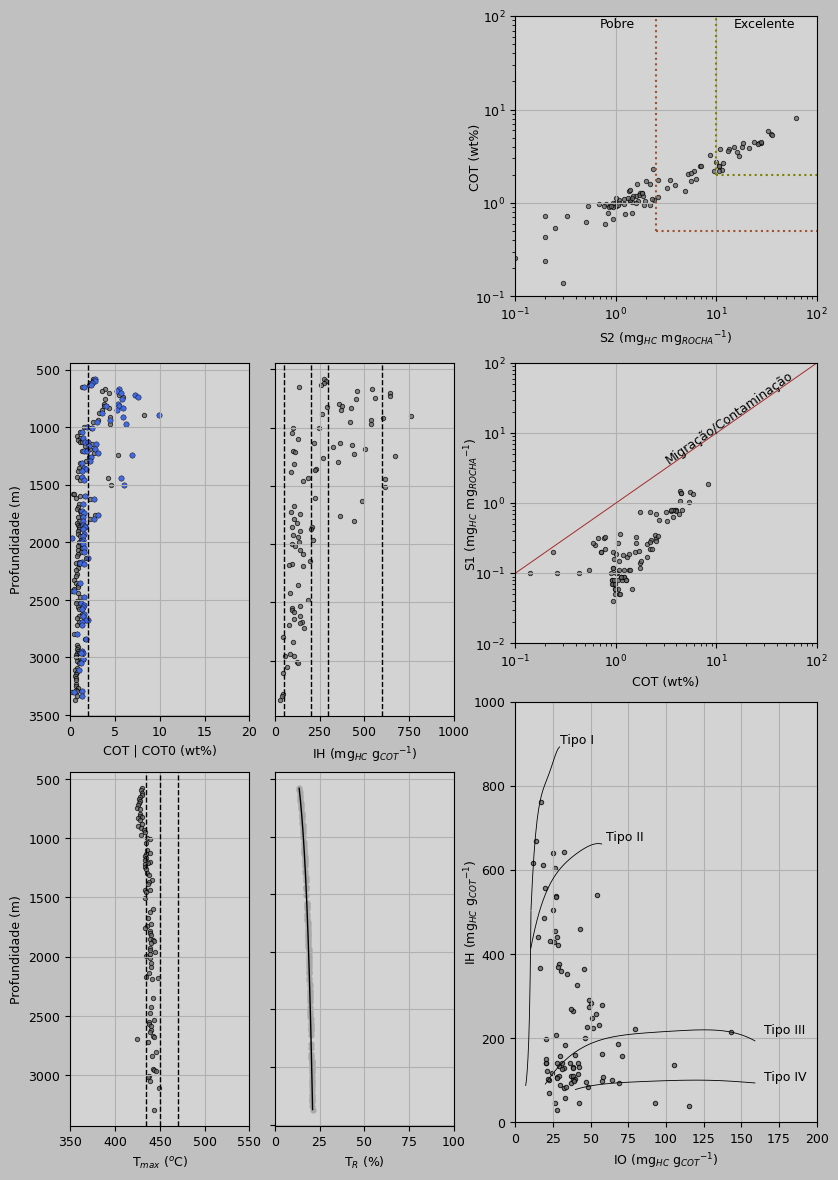

In [112]:
# Figura com tamanho A4

a4_width = 8.27  # inches
a4_height = 11.69  # inches

fig = plt.figure(figsize=(a4_width, a4_height), layout='constrained')

# Grid

L1 = GridSpec(3,4, figure=fig, width_ratios=[1, 1,1,2], height_ratios=[1,1, 1.5])
L2 = GridSpec(3,4, figure=fig)

# Posição dos gráficos 

ax1=fig.add_subplot(L2[1,0]) #==== COT ======#
ax2=fig.add_subplot(L2[1,1]) #==== IH ======#
ax3=fig.add_subplot(L2[2,0]) #==== Tmax ======#
ax4=fig.add_subplot(L2[2,1]) #==== Tr (log) ======#
ax5=fig.add_subplot(L1[2,-1]) #=== Van krevelen ===#
#ax5_1=fig.add_subplot(L1[2,-1])
#ax5_12=fig.add_subplot(L1[2,-1])
#ax5_2=fig.add_subplot(L1[2,-1])
#ax5_3=fig.add_subplot(L1[2,-1])
#ax5_4=fig.add_subplot(L1[2,-1])
ax6=fig.add_subplot(L1[0,-1]) #===COT x S2 ====#
#ax7=fig.add_subplot(spec[2,3]) #=== OSI ===#
ax8=fig.add_subplot(L1[1,-1]) #== OSI (S1 x COT)==#
plt.style.use(custom_style)

#==== COT ======#

ax1.scatter(df["COT"], df["Profundidade"], color="dimgray",s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
ax1.scatter(df["COT0"], df["Profundidade"],s=15,c="royalblue", edgecolor="black", linewidth=0.3)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlim(0.0, 20.0)
ax1.axvline(2, color="black", linewidth=1, linestyle="--")
ax1.set_xlabel("COT | COT0 (wt%)")
ax1.set_ylabel("Profundidade (m)")

#==== IH ======#

ax2.scatter(df["IH"], df["Profundidade"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
ax2.axvline(600, color="black", linewidth=1, linestyle="--")
ax2.axvline(300, color="black", linewidth=1, linestyle="--")
ax2.axvline(200, color="black", linewidth=1, linestyle="--")
ax2.axvline(50, color="black", linewidth=1, linestyle="--")
ax2.set_xlabel("IH (mg$_{HC}$ g$_{COT}$$^{-1}$)")
ax2.set_xlim(0.0, 1000.0)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_yticklabels([])
ax2.set_ylabel("")

#==== Tmax ======#

ax3.scatter(df["Tmax"], df["Profundidade"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.axvline(435, color="black", linewidth=1, linestyle="--")
ax3.axvline(450, color="black", linewidth=1, linestyle="--")
ax3.axvline(470, color="black", linewidth=1, linestyle="--")
ax3.set_xlabel("T$_{max}$ ($^{o}$C)")
ax3.set_ylabel("Profundidade (m)")
ax3.set_xlim(350,550)

#==== Tr (log) ======#

if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
    a=mdn
elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
    a=min
else:
    a=med

ax4.plot(a*100, y, color='black', linewidth=1)
ax4.scatter(a*100, y, color='darkgray', s=12)
ax4.set_ylim(ax4.get_ylim()[::-1])
ax4.set_xlabel("T$_R$ (%)")
ax4.set_ylabel("")
ax4.set_yticklabels([])
ax4.set_xlim(0,100)

#====== Van krevelen ======#

range1=np.arange(10.5,30)
range12=np.arange(7.0,11.0,0.5)
range2=np.arange(10.4,58)
range3=np.arange(20,160)
range4=np.arange(40,160)
IH1=[]
IH12=[]
IH2=[]
IH3=[]
IH4=[]
for x in range1:
    T1 =  (-0.01042*(x**4)) + (0.9557*(x**3)) - (32.58*(x**2)) + (499.2*x) - 2125
    IH1.append(T1)
IH1_df=pd.DataFrame(IH1)
for x in range12:
    T12 = (3.107862854*(x**4)) - (96.793044354*(x**3)) + (1144.1301092*(x**2)) - (6036.4831648*x) + 12018.171211
    IH12.append(T12)
IH12_df=pd.DataFrame(IH12)
for x in range2:
    T2 = ((-0.00011683)*(x**4)) + (0.01916740603*(x**3)) - (1.2250636761*(x**2)) + (38.6173184469*x) + 124.366169274
    IH2.append(T2)
IH2_df=pd.DataFrame(IH2)
for x in range3:
    T3 = ((-2.543*(10**-6)*(x**4))) + (0.00101*(x**3)) - (0.1514*(x**2)) + (10.38*x) - 64.21
    IH3.append(T3)
IH3_df=pd.DataFrame(IH3)
for x in range4:
    T4 = ((1.047*(10**-8))*(x**5))-((5.815*(10**-6))*(x**4)) + (0.001245*(x**3)) - (0.1309*(x**2)) + (6.969*x) - 57.58
    IH4.append(T4)
IH4_df=pd.DataFrame(IH4)

ax5.plot(range1,IH1_df, c="black", linewidth=0.6)
ax5.plot(range12,IH12_df, c="black", linewidth=0.6)
ax5.plot(range2,IH2_df, c="black", linewidth=0.6)
ax5.plot(range3,IH3_df, c="black", linewidth=0.6)
ax5.plot(range4,IH4_df, c="black", linewidth=0.6)
ax5.scatter(df["IO"], df["IH"], color="dimgray", edgecolor="black", s=10, linewidth=0.75, alpha=0.8)
ax5.set_xlim(0,200)
ax5.set_ylim(0,1000)
ax5.set_ylabel("IH (mg$_{HC}$ g$_{COT}$$^{-1}$)")
ax5.set_xlabel("IO (mg$_{HC}$ g$_{COT}$$^{-1}$)")
ax5.yaxis.set_label_coords(-0.11, 0.5)
ax5.text(30,900, "Tipo I")
ax5.text(60,670, "Tipo II")
ax5.text(165,210, "Tipo III")
ax5.text(165,100, "Tipo IV")

#======== COT x S2 ========#

ax6.scatter(df["S2"], df["COT"], color="dimgray",s=10,edgecolor='black', linewidth=0.65, alpha=0.75 )
ax6.set_xscale("log")
ax6.set_yscale("log")
ax6.plot([10,10],[2,100], color="olive", linestyle=":", linewidth=1.5)
ax6.plot([10,100],[2,2], color="olive", linestyle=":", linewidth=1.5)
ax6.plot([2.5,2.5],[0.5,100], color="sienna", linestyle=":", linewidth=1.5)
ax6.plot([2.5,100],[0.5,0.5], color="sienna", linestyle=":", linewidth=1.5)
ax6.text(15,75, "Excelente")
ax6.text(0.7,75, "Pobre")
ax6.set_xlabel("S2 (mg$_{HC}$ mg$_{ROCHA}$$^{-1}$)")
ax6.set_ylabel("COT (wt%)")
ax6.yaxis.set_label_coords(-0.11, 0.5)
ax6.set_xlim(0.1,100)
ax6.set_ylim(0.1,100)

#========== OSI ===========#

#ax7.scatter(df["OSI"], df["Profundidade"], color="black")
#ax7.set_ylim(ax1.get_ylim()[::-1])
#ax7.set_xlim(0.0, 200.0)
#ax7.axvline(100, color="darkred", linestyle="--")
#ax7.set_yticklabels([])
#ax7.set_xlabel("OSI (wt%)")
#ax7.set_ylabel("")

#========= OSI (S1 x COT)============#

ax8.plot([0,100],[0,100], color="brown", linestyle="-", linewidth=0.7)
ax8.scatter(df["COT"], df["S1"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
ax8.set_ylabel("S1 (mg$_{HC}$ mg$_{ROCHA}$$^{-1}$)")
ax8.set_xlabel("COT (wt%)")
ax8.yaxis.set_label_coords(-0.11, 0.5)
ax8.text(3.0, 3.7, "Migração/Contaminação", rotation=35)
ax8.set_xlim(0.1,100.0)
ax8.set_ylim(0.01,100.0)
ax8.set_xscale("log")
ax8.set_yscale("log")


plt.savefig("Outputs_Figuras/Figura.pdf")



# Planilha de Output

In [ ]:
mdn1 = df["Tr_IH_Log (mdn)"]
min1 = df["Tr_IH_Log (min)"]
med1 = df["Tr_IH_Log (med)"]

if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
    b=mdn
elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
    b=min
else:
    b=med
df_csv=df[["Profundidade","COT","S1","S2","S3","Tmax","IH","IO","Cluster"]]
df_csv[["COTa","IH0a"]]=df[["COTa","IH0a"]].round(2)
df_csv["Ro (calculada)"]=df["Ro (calculada)"]
df_csv["Querogênio (Tipo)"]=df["Querogênio"]
df_csv["Tr_Ro_Log"]=df["Tr_Ro_Log"].round(3)
df_csv["Tr_IH_Log"]=b.round(3) 
df_csv[["COT0","S20","IH0","OSI"]]=df[["COT0","S20","IH0","OSI"]].round(2)
df_csv.to_csv("Outputs_Planilhas/Planilha.csv")
df_csv

## Parâmetros adicionais

* Índice de Produção Inicial: IP0 = 0.02
* Índice de Produção: PI = S1/(S1+S2)
* f = (1-(HI*(1200-(HI0/(1-PI0))))/(HI0*(1200-(HI/(1-PI)))))
* Volume de óleo expelido: S1exp = (1000*(TOC0-TOC))/(83.33-TOC) 
* Eficiência de expulsão: ExEf = 1 - (((1-f)*(PI/(1-PI)))/(f+(1-PI0)))

##### Índice de produção

In [ ]:
df["Índice de Produção"]=(df["S1"]/(df["S1"]+df["S2"]))
df

##### Parâmetro "f"

In [ ]:
IP0=0.02
df["f"] = (1-(df["IH"]*(1200-(df["IH0"]/(1-IP0))))/(df["IH0"]*(1200-(df["IH"]/(1-df["Índice de Produção"])))))
df

##### Volume de óleo expelido

##### Assumindo: 

* Densidade do óleo e xisto: 850 mg/cm3 e 2.4g/cm3
* Espessura: 10m
* Área: 1 acre 

In [ ]:
df["S1 expelido (barris/acre)"] = ((1000*(df["COT0"]-df["COT"]))/(83.33-df["COT"])/850)*7758*10
df

##### Eficiência de expulsão

In [ ]:
IP0=0.02
df["Eficiência de Expulsão (%)"] = (1 - (((1-df["f"])*(df["Índice de Produção"]/(1-df["Índice de Produção"])))/(df["f"]+(IP0/(1-IP0)))))*100
ExEf_cor=[]
for i in df["Eficiência de Expulsão (%)"]:
    if i<0:
        ExEf_cor.append(0)
    elif i>100:
        ExEf_cor.append(100)
    else:
        ExEf_cor.append(i)
ExEf=pd.DataFrame(ExEf_cor)
df["Eficiência de Expulsão (%)"]=ExEf
df


#### Estatística descritiva e descrição qualitativa

* indice de Produção
* Eficiência de expulsão
* Óleo expelido (barris/acre)
* Fonte ( em acordo com tipo de querogênio predominante)
* Estágio de maturação do poço

In [ ]:
PI = df["Índice de Produção"]
index=["Média", "Mediana","Desvio Padrão", "Mínimo", "Máximo"]
mean=PI.mean().round(2)
median=PI.median().round(2)
std_dev=PI.std().round(2)
val_min=PI.min().round(2)
val_max=PI.max().round(2)
pi_stat=[mean, median, std_dev, val_min, val_max]
STAT=pd.DataFrame(pi_stat, columns=["IP"] ,index=index)
STAT

In [ ]:
EE = df["Eficiência de Expulsão (%)"]
index=["Média", "Mediana","Desvio Padrão", "Mínimo", "Máximo"]
mean=EE.mean().round(2)
median=EE.median().round(2)
std_dev=EE.std().round(2)
val_min=EE.min().round(2)
val_max=EE.max().round(2)
ee_stat=[mean, median, std_dev, val_min, val_max]
STAT2=pd.DataFrame(ee_stat, columns=["Eficiência de Expulsão (%)"] ,index=index)
STAT["Eficiência de Expulsão (%)"]=STAT2
STAT

In [ ]:
OE = df["S1 expelido (barris/acre)"]
index=["Média", "Mediana","Desvio Padrão", "Mínimo", "Máximo"]
mean=OE.mean().round(2)
median=OE.median().round(2)
std_dev=OE.std().round(2)
val_min=OE.min().round(2)
val_max=OE.max().round(2)
ee_stat=[mean, median, std_dev, val_min, val_max]
STAT3=pd.DataFrame(ee_stat, columns=["S1 expelido (barris/acre)"] ,index=index)
STAT["S1 expelido (barris/acre)"]=STAT3
STAT